# 0. はじめに
この notebook は、 IOAI 2025 対策サーバー第一回コンペ復習会の baseline notebook です。自作のベースラインを使わない人はこのベースラインを使ってください。
## 0.1. このコンペについて
- エッセイが与えられて、その読みやすさを評価するコンペです。
- 読みやすさは -3 から 1 程度の値の範囲内で人の手によってつけられています
- 評価指標は [RMSE](https://ja.wikipedia.org/wiki/%E4%BA%8C%E4%B9%97%E5%B9%B3%E5%9D%87%E5%B9%B3%E6%96%B9%E6%A0%B9%E8%AA%A4%E5%B7%AE) です。
- **このコンペは code competiton です。推論用の notebook を提出してください。推論用 notebook では、事前に kaggle dataset としてアップロードした model は使えますが、 notebook 内でインターネットが使用できないことなどに留意してください。**

## 0.2. 今回の目標
- 初心者 : 自然言語処理タスクのコンペに対する基本的なアプローチを学ぶ。 transformers などの基本的な書き方や、 BERT を始めとした自然言語処理でよく使われるモデルについて学ぶ。
- 中級者 : BERT を始めとした自然言語処理モデルの fine-tuning の方法について学ぶ。自然言語処理のコンペでよく出てくるテクニックについて学ぶ。
- 上級者 : 上位陣のソリューションを学ぶ。実験を効率的に行う。できるだけ高いスコアを出す。

## 0.3. データについて
- train, test, sample_submission の 3 つの csv ファイルが与えられます。
- train と test には以下の列が含まれています。
   - id : 文章を識別する id
   - url_legal : 元の文章の URL 、ただし欠損あり、 train.csv のみ
   - licence : ライセンス、ただし欠損あり、 train.csv のみ
   - excerpt : 文章
   - target : 目的変数（今回の場合は人の手によって採点されたエッセイの読みやすさ）
   - standard_error : 審査員間の評価の標準誤差、 train.csv のみ

- 基本的には id, excerpt, target のみ使えば大丈夫です。
## 0.4. コンペ復習会について
- 解く時は基本的に自由にやってもらって大丈夫です。ただし、 IOAI に近い形式にするなら検索 OK 、このコンペの notebook と discussion は参考にしない、とかがいいと思います。
- 解く期間の終了日は 1/13 です。その後、上位陣の解法を見たり、それぞれの解法を見たりします。一つの google slide をみんなで編集する予定です。
# 0.5. その他
- 何でもわからないところがあったらどんどん質問してください！
- 一部説明は NN や Transformer 、 BERT の基本的な知識があることを前提に書かれています。わからない所があれば適宜調べるか質問してください。
- 初心者じゃない人へ : 一部記述がおかしかったりしたら指摘してくださるとありがたいです！

# 1. 必要なライブラリの import
知らないライブラリがあったら各自で調べてください。

In [1]:
import os
import random
import math
import gc
import time
import copy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


import transformers

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


一応 GPU 環境かどうかをチェックします。 GPU 環境前提でコードを書いたので気をつけてください。 "cuda" が出力されれば大丈夫です。

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 2. 諸々の設定
random_seed を固定したり、諸々のハイパラを指定していきます。  
また、コード公開段階では **debug_one_epoch = True** になっています。 **これを False にしないと 20 epoch 分学習しない** ので気をつけてください。


In [3]:
class CFG :
    debug_one_epoch=True
    debug_one_fold=False
    run_cv=True
    only_infer=False
    num_workers=4
    num_epochs=20
    warmup_prop=0.1
    lr=5e-5
    max_len=512
    batch_size=16
    early_stopping_rounds=5
    random_seed=42
    model_path="../input/huggingface-bert/bert-base-uncased" 
    pretrained_path=""
    optimizer=torch.optim.AdamW
    criterion=torch.nn.MSELoss()
    device=device
    fold=5
    
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(CFG.random_seed)

In [4]:
if CFG.debug_one_epoch:
    CFG.num_epochs = 1

それぞれの説明です
- debug_one_epoch : 1epoch で終了させるか
- debug_one_fold : 1fold で終了させるか
- run_cv : cross validation を行うかどうか
- only_infer : 学習済モデルを使って 推論のみを行うかどうか
- num_workers :  同時に並列処理する数
- num_epochs : 何 epoch 学習させるか
- warmup_prop : 全体のステップ数の何 % を学習率の warmup に使うか。使わない場合は 0
- lr : モデルの learning rate
- max_len : モデルに入力するトークン数の最大長
- batch_size : バッチサイズ
- early_stopping_round : 何 epoch validation に対するスコアが改善しなかったら学習を止めるか
- random_seed : random_seed
- model_path : model の path 。kaggle 環境では、データセットを import してそのディレクトリのパスを指定してください。ローカルであれば "bert-base-uncased" で大丈夫です。他のモデルを使いたい場合は適宜変更してください。
- pretrained_path : 事前に学習させたモデルがある場合はここにそのディレクトリを指定する。ディレクトリ内に fold 数分の学習済モデルがあることを想定。
- optimizer : optimizer
- criterion : 損失関数
- device : 学習や推論を行う device　を指定する。今回は GPU 想定
- fold : 何 fold の cross validation をするか

# 3. データを見よう
csv ファイルから pandas dataframe にして、簡単な EDA をします。

In [5]:
train = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
test = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
submission = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")

In [6]:
train.head(3)

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676


In [7]:
test.head(3)

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...


In [8]:
submission.head(3)

,id,target
0,c0f722661,0.0
1,f0953f0a5,0.0
2,0df072751,0.0


スコアがどんな感じか見ます。    

In [9]:
train["target"].describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

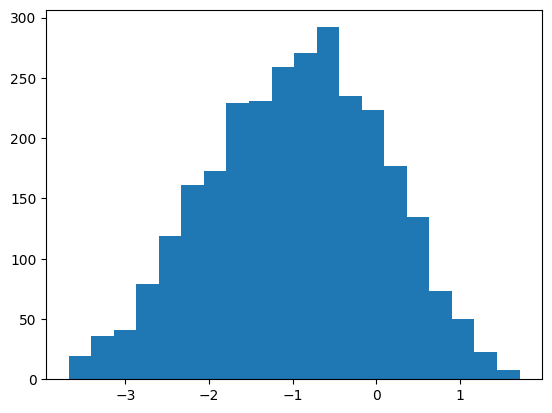

In [10]:
plt.hist(train["target"], bins=20)
plt.show()

文章がどんな感じか見ます。

In [11]:
print(train.excerpt[0])

When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wear snowshoes.


# 4. この notebook の方針と BERT について
## 4.1. 方針について
今回で一番むずかしいところの一つです。頑張りましょう。  
以下、いくつかの文の集合を文章と定義します。
今回は、文章 -> BERT -> 求めたいスコア、という感じで文章を変換していきます。より正確には、 BERT が出力した文章の埋込表現を使って分類タスクを解くように設計された transformers.BertForSequenceClassification の出力クラス数を 1 にすることで回帰タスクに対応させます。
## 4.2. BERT について
せっかくなので、 BERT の使い方について学んでいきましょう。 BERT についての詳しい解説はここでは割愛します。細かい点は [この記事](https://qiita.com/omiita/items/72998858efc19a368e50) や [この記事](https://data-analytics.fun/2020/05/02/understanding-bert/) などを参考に各自理解してください。  
## 4.3. Tokenizer について
（簡単に言うと） BERT のような言語モデルは文章を Tokenizer で数字の列にしたあと、それをモデルに入力します。 Tokenizer では、文章を subword という単位に分割したり、それに id を付与したり、文章毎に違うトークンの長さを特殊トークンを付与して整えたりします。  
詳しくは [この記事](https://zenn.dev/robes/articles/b6708032855a9c) とかを参考にしてください。  
Tokenizer の学習をテーマにした問題は、 IOAI のサンプル問題及び IOAI2024 at-home の両方で出されています。 [この記事](https://blog.recruit.co.jp/data/articles/huggingface_tokenizer/) や IOAI 2024 の日本代表コードを参考に勉強しておくと良いことがあるかも知れません。  

In [12]:
tokenizer = transformers.AutoTokenizer.from_pretrained(CFG.model_path)
test_txt = "I have a pen and an apple."
tokenizer.tokenize(test_txt)

['i', 'have', 'a', 'pen', 'and', 'an', 'apple', '.']

テキストがいい感じに分割されました。

In [13]:
tokenizer.encode_plus(test_txt, max_length=32, padding="max_length", truncation=True, return_tensors="pt")

{'input_ids': tensor([[ 101, 1045, 2031, 1037, 7279, 1998, 2019, 6207, 1012,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

input_ids は tokenizer でトークン化した単語を表す ID の配列、 token_type は 2 つの文章を繋げた時にその文章を区別する id の配列（恐らく BERT の事前学習の時に、よく使っています）、 attention_mask は各トークンが padding かどうかを示す 01 の配列です。  
max_len をいじると以下のようになります。

In [14]:
tokenizer.encode_plus(test_txt, max_length=5, padding="max_length", truncation=True, return_tensors="pt")

{'input_ids': tensor([[ 101, 1045, 2031, 1037,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

decode も出来ます。

In [15]:
tokenize_result = tokenizer.encode_plus(test_txt, max_length=32, padding="max_length", truncation=True, return_tensors="pt")
tokenizer.decode(tokenize_result["input_ids"].squeeze())

'[CLS] i have a pen and an apple. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

文章の先頭に [CLS] という特殊トークンが付与されています。これは、一つの文章の特徴を集約するトークンだと思ってください。（ BERT の動く仕組みを理解していないと本質は分からないのですが、ここでは割愛します）  
また、 [SEP] というのは文と文を区切るための特殊トークンです。  
[PAD] は先述した max_length の長さに揃えるための特殊トークンです。  
また、豆知識ですが uncased というのは大文字と小文字を区別しない、という意味で、実際に decode すると全て小文字になっていることが確認できるかと思います。

## 4.4. BERT について
本体の使い方説明です。今回は transformers.AutoModel を使って実装していきます。入力として tokenizer によって作られた input_ids と attention_mask を必要とします。 

In [16]:
model = transformers.AutoModel.from_pretrained(CFG.model_path)

In [17]:
output = model(**tokenize_result)
print(output.keys())

odict_keys(['last_hidden_state', 'pooler_output'])


In [18]:
print("last_hidden_state shape : ", output.last_hidden_state.shape)
print("pooler_output shape : ", output.pooler_output.shape)

last_hidden_state shape :  torch.Size([1, 32, 768])
pooler_output shape :  torch.Size([1, 768])


last_hidden_stte は各トークンに対する埋込ベクトル、 pooler_output_shape は [CLS] という特殊トークンの埋込表現を pooling 層に通した後の埋込表現です。

# 5. モデルを学習させよう
今回は Pytorch で書いていきます。現在の kaggle を始めとした機械学習コンペの圧倒的マジョリティなのと、 IOAI 本番でも恐らく Pytorch を書くことになるからです。他にも tensorflow や jax などのフレームワークがあります。後者は高速に動くのが魅力で一部の人は好んで使っているので興味がある人は調べてみてください。 ~~Google がスポンサーやってるのに IOAI では tensorflow と jax を使わないらしい。 jax は一部セミナーで使いました。~~  
## 5.1 Pytorch の Dataset と DataLoader を作ろう
Dataset や DataLoader については [これ](https://qiita.com/mathlive/items/2a512831878b8018db02) とかに書いてあります。簡単に言うと、 Dataset を作ってそれを DataLoader で取り出すイメージです。  


In [19]:
class CommonlitDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len=512, test=False):
        # テキストデータとターゲットデータを受け取ります
        self.texts = texts
        if test == False:
            self.targets = targets
        self.test = test
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        # tokenizer を使って BERT の入力形式に変換します
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        # いらない次元を削除します
        ids = inputs["input_ids"].squeeze()
        mask = inputs["attention_mask"].squeeze()
        
        # test の場合は targets がないので、適当な値を返します
        targets = torch.tensor(-100, dtype=torch.float)
        if self.test == False:
            targets = torch.tensor(self.targets[idx], dtype=torch.float)
            
        return {
            "input_ids": torch.tensor(ids, dtype=torch.long),
            "attention_mask": torch.tensor(mask, dtype=torch.long),
            "targets":targets
        }

In [20]:
# tokenizer を読み込みます。
tokenizer = transformers.AutoTokenizer.from_pretrained(CFG.model_path)

# cross validation を行う都合でここでは test dataset だけ作ります。
test_dataset = CommonlitDataset(texts=test["excerpt"].values, targets=None, tokenizer=tokenizer, max_len=CFG.max_len, test=True)
test_dataloader = DataLoader(test_dataset,batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
for i in test_dataloader:
    print(i)
    break


{'input_ids': tensor([[  101,  2026,  3246,  ...,     0,     0,     0],
        [  101, 11089,  3723,  ...,     0,     0,     0],
        [  101,  2009,  2001,  ...,     0,     0,     0],
        ...,
        [  101,  2139,  8569,  ...,     0,     0,     0],
        [  101,  2000,  4863,  ...,     0,     0,     0],
        [  101,  6501,  2050,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'targets': tensor([-100., -100., -100., -100., -100., -100., -100.])}


## 5.2 AutoModelForSequenceClassification を使おう

先程の AutoModel に分類用のヘッドが追加されたのが AutoModelForSequenceClassification です。今回はこのモデルを使います。

In [21]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(CFG.model_path, num_labels=1)
model.to(CFG.device) # model を GPU に送ります

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../input/huggingface-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

model の中身が上に出力されましたね。
とりあえず model が正常に動くかどうか試してみましょう

In [22]:
for i in test_dataloader :
    # input_ids, attention_mask, targets は GPU 上に無いので、to で GPU 上に持っていきます。
    input_ids = i["input_ids"].to(CFG.device)
    attention_mask = i["attention_mask"].to(CFG.device)
    targets = i["targets"].to(CFG.device)
    print("input_ids shape:", input_ids.shape)
    print("attention_mask shape:", attention_mask.shape)

    # 出力結果を見てみましょう。
    outputs = model(input_ids, attention_mask)
    print(outputs)
    print(outputs.logits.squeeze(-1).shape)
    break

input_ids shape: torch.Size([7, 512])
attention_mask shape: torch.Size([7, 512])
SequenceClassifierOutput(loss=None, logits=tensor([[0.2908],
        [0.3047],
        [0.3469],
        [0.3470],
        [0.3907],
        [0.3976],
        [0.4307]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
torch.Size([7])


input のデータ数と同数の値が出てきているので大丈夫そうですね。 logits のところだけ後で使います。

## 5.3. train one epoch を定義しよう
ここでは、 Pytorch の学習で必要な関数を記述していきます。基本的な Pytorch のループの書き方については [これ](https://yutaroogawa.github.io/pytorch_tutorials_jp/) とかを参考にしてください。今回はわかりやすく書いていますが（この部分に関しては）次回以降は飛ばします。  
去年の日本代表コーディング規則にもあったのですが、 pytorch で学習と推論のループを書くときは train_one_step や train_one_epoch のような関数を定義してあげると、実装がみやすくなります。  
余談ですが、実はラッパーを用いてこれ以上に簡潔に書く方法 ([transformers.trainer](https://qiita.com/nipo/items/44ce3aaf6acd4e2649d1) を用いた実装 ) は存在するのですが、中の挙動があまりにも不透明、ということで去年の日本代表コーディング規則では問題からの指定がない限りは禁止、ということにしていました。  

In [23]:
def train_one_epoch(model, dataloader, optimizer, scheduler, criterion):
    model.to(CFG.device)
    
    # model を train モードにします
    model.train()
    
    # loss と予測値を保存するためのリストを作ります
    losses = []
    preds = []
    
    # dataloader からデータを取り出してループを回します。このループ全体が 1 epoch 、ループ 1 回が 1 batch になります
    for data in tqdm(dataloader):
        # データの取り出しと GPU への転送
        input_ids = data["input_ids"].to(CFG.device)
        attention_mask = data["attention_mask"].to(CFG.device)
        targets = data["targets"].to(CFG.device)
        
        optimizer.zero_grad() # 勾配を初期化します
        outputs = model(input_ids, attention_mask) # モデルの出力を得ます
        loss = criterion(outputs.logits.squeeze(-1), targets) # loss を計算します。ついでに squeeze していらない次元を潰します
        loss.backward() # 勾配を計算します
        pred = outputs.logits.squeeze(-1).detach().cpu().numpy() # 予測値を取り出します
        optimizer.step() # パラメータを更新します
        scheduler.step() # scheduler を更新します
        losses.append(loss.item()) # loss を保存します
        preds.append(pred) # 予測値を保存します
    
    return np.mean(losses), np.concatenate(preds)

## 5.4. eval one epoch を定義しよう
eval に関しても同様に定義していきます。 model.eval() とか torch.no_grad とかを忘れないように。

In [24]:
def eval_one_epoch(model, dataloader, criterion):
    model.to(CFG.device)
    # 今回は model を評価するだけなので、model.eval() で評価モードにします
    model.eval()

    losses = []
    preds = []
    for data in tqdm(dataloader):
        with torch.no_grad(): # 勾配を計算しないので、torch.no_grad() で囲みます
            # 以下は train の時の学習させる部分が無いだけなので説明は割愛します。
            input_ids = data["input_ids"].to(CFG.device)
            attention_mask = data["attention_mask"].to(CFG.device)
            targets = data["targets"].to(CFG.device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs.logits.squeeze(-1), targets)
            pred = outputs.logits.squeeze(-1).cpu().numpy()
            losses.append(loss.item())
            preds.append(pred)
            
    return np.mean(losses), np.concatenate(preds)

## 5.5. Cross Validation で学習を回そう
いよいよ学習を回していきます。機械学習コンペに出たことがある人ならおなじみの CV(Cross Validation) を組んでいきます。参考記事は [こちら](https://zenn.dev/yuto_mo/articles/c5b37a569d5673) です。簡単に言うと、モデルの性能を手元のデータだけで評価しようね、という話です。  
また、一部（特に機械学習コンペ中心？）で使われているテクなのですが、 CV のそれぞれの fold で train した model の、 test に対する推論結果の平均を取ることで擬似的に fold 数分のモデルをアンサンブルする、というテクがあるのでそれを実践していきます。

In [25]:
def run_train_cv(train, test, tokenizer):
    kf = KFold(n_splits=CFG.fold, shuffle=True, random_state=CFG.random_seed) # KFold で分割します
    test_preds = [] # test の予測値の保管用
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
        print(f"=====================fold {fold}=====================")
        # train と valid の DataLoader を作ります
        train_dataset = CommonlitDataset(texts=train.loc[train_idx, "excerpt"].values, targets=train.loc[train_idx, "target"].values, tokenizer=tokenizer, max_len=CFG.max_len, test=False)
        valid_dataset = CommonlitDataset(texts=train.loc[valid_idx, "excerpt"].values, targets=train.loc[valid_idx, "target"].values, tokenizer=tokenizer, max_len=CFG.max_len, test=False)
        train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, pin_memory=True)
        valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

        # model, optimizer, scheduler, criterion を作ります。
        model = transformers.AutoModelForSequenceClassification.from_pretrained(CFG.model_path, num_labels=1) 

        optimizer = CFG.optimizer(model.parameters(), lr=CFG.lr)
        scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataloader)*CFG.num_epochs*CFG.warmup_prop, num_training_steps=len(train_dataloader)*CFG.num_epochs)
        criterion = CFG.criterion.to(CFG.device)

        # 最適なモデルを保存するためにいくつかの変数を用意します。
        best_rmse = np.inf
        best_model = None
        best_preds = None
        best_epoch = 0

        # 学習を行います。このループの中の 1 回が 1 epoch になります
        for epoch in range(CFG.num_epochs):
            # train と valid の loss と予測値、 valid の RMSE を取得します
            train_loss, train_preds = train_one_epoch(model, train_dataloader, optimizer, scheduler, criterion)
            valid_loss, valid_preds = eval_one_epoch(model, valid_dataloader, criterion)
            valid_rmse = math.sqrt(mean_squared_error(valid_preds, train.loc[valid_idx, 'target'].values))
            print(f"epoch {epoch} train_loss : {train_loss}, valid_loss : {valid_loss}, valid_rmse :{valid_rmse}")
            
            # valid の RMSE が最小の時にモデルを保存します
            if valid_rmse < best_rmse:
                print("best rmse is updated, save model")
                best_rmse = valid_rmse
                best_model = copy.deepcopy(model)
                best_preds = valid_preds
                best_epoch = epoch
            
            # CFG.early_stopping_rounds の epoch 数分ずっと改善しなかったら学習を止める、 early stopping という手法です。
            if CFG.early_stopping_rounds >= 0 and best_epoch-epoch >= CFG.early_stopping_rounds:
                print("early stopping")
                break
        
        torch.save(best_model.state_dict(), f"model_{fold}.pth") # 一番良かった model を保存します
    
        test_preds.append(eval_one_epoch(best_model, test_dataloader, criterion)[1]) # test の予測値を保存します
        
        # 使わない変数を削除してメモリを解放します
        del model
        torch.cuda.empty_cache()

        if CFG.debug_one_fold == True: # debug で 1 fold だけ回す場合は break します
            break

    return test_preds

# 6. 推論専門の関数を作ろう
kaggle でコードを提出する際は、いちいちモデルを学習するのではなく、学習させたモデルを dataset としてアップロードし、それを使って推論のみを行う事が殆どです。そのため、推論専用の関数も書きます。

In [26]:
def only_infer(test, model):
    # test の DataLoader を作ります
    test_dataset = CommonlitDataset(texts=test["excerpt"].values, targets=None, tokenizer=tokenizer, max_len=CFG.max_len, test=True)
    test_dataloader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
    test_preds = [] # test の予測値の保管用
    
    for fold in range(CFG.fold):
        model = transformers.AutoModelForSequenceClassification.from_pretrained(CFG.model_path, num_labels=1)
        model.load_state_dict(torch.load(f"{CFG.pretrained_path}/model_{fold}.pth")) # ここで保存した model の重みを読み込みます
        test_preds.append(eval_one_epoch(model, test_dataloader)[1])

    return test_preds

# 7. 上記の関数を実行していこう
CFG の設定に基づいてコードを実行していきます。

In [27]:
def main():
    if CFG.run_cv == True:
        test_preds = run_train_cv(train, test, tokenizer)
        
    elif CFG.only_infer == True:
        test_preds = only_infer(test, tokenizer)

    submission["target"] = np.mean(test_preds, axis=0)
    submission.to_csv("submission.csv", index=False)
    
if __name__ == "__main__":
    main()

=====================fold 0=====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../input/huggingface-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch 0 train_loss : 0.6634076153728324, valid_loss : 0.3500087733070056, valid_rmse :0.5943513917952318
best rmse is updated, save model


  0%|          | 0/1 [00:00<?, ?it/s]

=====================fold 1=====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../input/huggingface-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/142 [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    self._close()
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
        self._close()
  File "/usr/lib/python3.10/multiprocessi

  0%|          | 0/36 [00:00<?, ?it/s]

epoch 0 train_loss : 0.6127231044458671, valid_loss : 0.39116936052838963, valid_rmse :0.6243984936700546
best rmse is updated, save model


  0%|          | 0/1 [00:00<?, ?it/s]

=====================fold 2=====================


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
Exception ignored in: <function _ConnectionBase.__del__ at 0x7d33744268c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
        _close(self._handle)
OSError:     _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling 

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch 0 train_loss : 0.5731930298284745, valid_loss : 0.38900235957569546, valid_rmse :0.62187606978387
best rmse is updated, save model


  0%|          | 0/1 [00:00<?, ?it/s]

=====================fold 3=====================


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
:
Traceback (most recent call last):
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    self.run()
    _close(self._handle)
OSError: [Errno 9] Bad file

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch 0 train_loss : 0.5802129188054045, valid_loss : 0.36246047334538567, valid_rmse :0.59960583634014
best rmse is updated, save model


  0%|          | 0/1 [00:00<?, ?it/s]

=====================fold 4=====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../input/huggingface-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch 0 train_loss : 0.7995401992344521, valid_loss : 0.35470427614119315, valid_rmse :0.596842203083148
best rmse is updated, save model


  0%|          | 0/1 [00:00<?, ?it/s]

# 8. 工夫のしどころ、キーワード
- BERT の fine-tuning （全員向け） : このコンペのネタバレを含みますが、[BERT の fine-tuning のみを取り扱った良記事](https://www.ai-shift.co.jp/techblog/2138) があります。まずは CFG の値を変えてみるところからでいいので、やってみましょう！
- アンサンブルをしよう（全員向け） : IOAI 2024 だとあまり試す機会が無かったものの、 kaggle に近い問題になればなるほど強力な手法です。身につけておきましょう。モデルを変える、埋込表現だけ使う、など色々な方法が考えられると思います！
- 使用モデルの検討（初中級者↑向け） : BERT にも様々な発展形があります。調べて使ってみましょう。また、本当に BERT がベストなのでしょうか......?
- アンサンブル方法の検討（中級者↑向け） : スタッキングを知っていますか？私は知っています。
- AMP 対応と data parallel（中上級者↑向け） : 名前に large が付いていたりする大きめのモデルだと学習と推論に時間がかかります。実験効率も大事なので対応させましょう。
- full train 戦略や random seed ensemble などの細かいテク（上級者向け） : ここらへんはコンペの振り返り記事を読み漁ると時々出てきます。類似コンペを調べてみましょう。
- 実験効率化（上級者向け） : 実験パイプラインの管理と高速化を大事にしましょう。wandb は特に at-home task での実験管理でとても便利です。また、先述の AMP を含めた高速化も実験数で勝負する時に重要になります。代表を強く意識しているのならば出来て損はないはずです。
- スコアアタック（上級者向け） : 数年前のコンペなので、最新の model や手法を使えばかなり面白いのではないでしょうか！